### [1] 패키지 불러오기

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image

### [2] Data transform 정의

In [2]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] Eye dataset 클래스

In [38]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torch

class NewEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        label = torch.tensor(item['label'], dtype=torch.long)

        return left_img, right_img, label

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        print(f"usable samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)


### [4] 구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [5] train_loader, val_loader, test_loader 구성

In [39]:
from torch.utils.data import DataLoader

# 경로 설정
json_path = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 데이터셋 생성
train_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=1, transform=TrainTransform)
val_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=2, transform=ValidTransform)
test_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=3, transform=ValidTransform)

# 최적화된 데이터로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable samples for group 1: 2603
usable samples for group 2: 200
usable samples for group 3: 100


### [6] 모델 정의

In [40]:
import torch.nn as nn
import timm
import torch

class SiameseEfficientNetV2Classifier(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(SiameseEfficientNetV2Classifier, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        # EfficientNetV2 output feature size = 1280
        self.classifier = nn.Sequential(
            nn.Linear(1280 * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)  # Binary classification
        )

    def forward(self, left, right):
        left_feat = self.backbone(left)    # (batch, 1280)
        right_feat = self.backbone(right)  # (batch, 1280)

        combined = torch.cat((left_feat, right_feat), dim=1)  # (batch, 2560)
        combined = self.dropout(combined)

        output = self.classifier(combined)
        return output


### [7] FocalLoss 클래스 정의

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### [8] 학습 루프 + loss 그래프

In [46]:
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = SiameseEfficientNetV2Classifier(dropout_p=0.3).to(device)

# 손실 함수
criterion = FocalLoss()

# 옵티마이저 (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 학습률 스케줄러
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 하이퍼파라미터
epochs = 20
best_val_loss = float('inf')

# 손실 저장 리스트
train_losses = []
val_losses = []
val_accuracies = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for left, right, labels in train_loader:
        left, right, labels = left.to(device), right.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(left, right)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left, right, labels in val_loader:
            left, right, labels = left.to(device), right.to(device), labels.to(device)

            outputs = model(left, right)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    # Best 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_effnetv23_1e-3.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# 손실 기록 저장
loss_history = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
}

with open('/content/drive/MyDrive/cv_project/01unimodal/loss_history_best_effnetv23_1e-3.json', 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history_best_effnetv23_1e-3.json 저장 완료!")


Best model updated at epoch 1 (Val Loss: 0.1647)
Epoch 1/20 | Train Loss: 0.1443 | Val Loss: 0.1647 | Val Acc: 0.6950 | LR: 0.001000
Epoch 2/20 | Train Loss: 0.1322 | Val Loss: 0.1729 | Val Acc: 0.5400 | LR: 0.001000
Epoch 3/20 | Train Loss: 0.1305 | Val Loss: 0.1817 | Val Acc: 0.6350 | LR: 0.001000
Best model updated at epoch 4 (Val Loss: 0.1527)
Epoch 4/20 | Train Loss: 0.1270 | Val Loss: 0.1527 | Val Acc: 0.7250 | LR: 0.001000
Epoch 5/20 | Train Loss: 0.1236 | Val Loss: 0.1747 | Val Acc: 0.5850 | LR: 0.001000
Epoch 6/20 | Train Loss: 0.1238 | Val Loss: 0.1832 | Val Acc: 0.5950 | LR: 0.001000
Epoch 7/20 | Train Loss: 0.1198 | Val Loss: 0.1727 | Val Acc: 0.6850 | LR: 0.001000
Epoch 8/20 | Train Loss: 0.1223 | Val Loss: 0.2005 | Val Acc: 0.6400 | LR: 0.001000
Epoch 9/20 | Train Loss: 0.1205 | Val Loss: 0.1649 | Val Acc: 0.7050 | LR: 0.001000
Epoch 10/20 | Train Loss: 0.1209 | Val Loss: 0.1575 | Val Acc: 0.6750 | LR: 0.001000
Epoch 11/20 | Train Loss: 0.1202 | Val Loss: 0.1981 | Val Acc

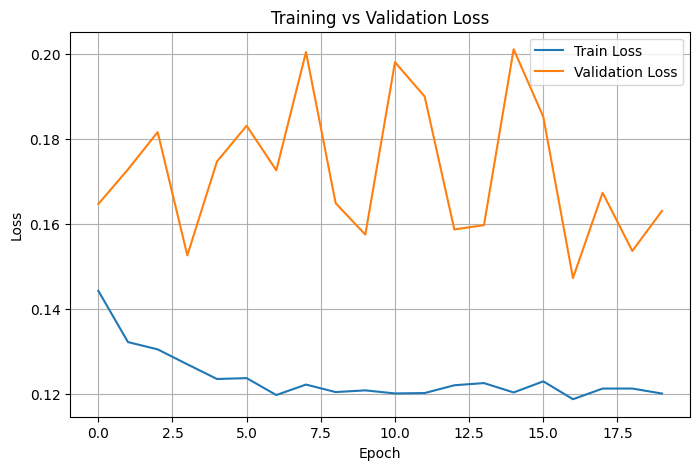

In [47]:
# 학습 종료 후 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### [9] predict_result.json 저장

In [48]:
from tqdm import tqdm
import torch
import json

# 모델 로드
model = SiameseEfficientNetV2Classifier(dropout_p=0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_effnetv23_1e-3.pth'))
model.eval()

# 예측 수행
results = []

with torch.no_grad():
    for left, right, labels in tqdm(test_loader, desc="Predicting"):
        left, right = left.to(device), right.to(device)
        outputs = model(left, right)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for true, pred, prob in zip(labels.cpu(), preds.cpu(), probs[:, 1].cpu()):
            results.append({
                "true_label": int(true.item()),
                "pred_label": int(pred.item()),
                "prob_thickened": float(prob.item())  # class 1 (두꺼워진) 확률
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result_best_effnetv23_1e-3.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result_best_effnetv23_1e-3.json


### [10] 평가 + AUC Curve 그리기

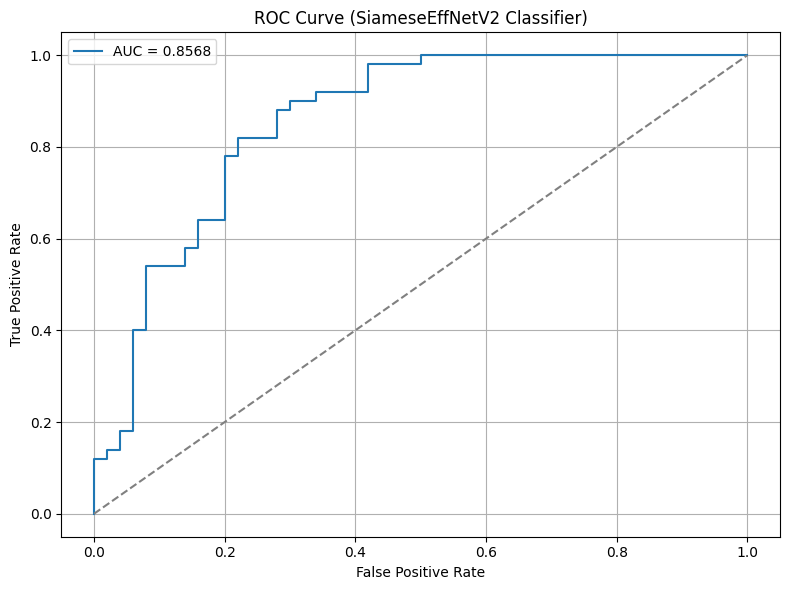

정확도 (Accuracy): 0.7800
AUC-ROC: 0.8568

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.97      0.58      0.72        50
   Thickened       0.70      0.98      0.82        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100


Confusion Matrix:
[[29 21]
 [ 1 49]]


In [49]:
import json
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result_best_effnetv23_1e-3.json", "r") as f:
    results = json.load(f)

# true, pred, prob 분리
y_true = [r["true_label"] for r in results]
y_pred = [r["pred_label"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# AUC-ROC 계산
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

# ROC Curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SiameseEffNetV2 Classifier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 추가 성능 출력
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))




---


## 전체 성능 요약
[단일모달 모델]
- 정확도 (Accuracy): 75.00%
- AUC-ROC: 82.58%

[현재 모델]
- 학습률: 1e-4
- 정확도 (Accuracy): 77.00%
- AUC-ROC: 85.08%